# Practice assignment: Model verification

In this programming assignment, you are going to work with a dataset based on the following data:

https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

_Citation:_

* _U. S. Department of Commerce, Bureau of the Census, Census Of Population And Housing 1990 United States: Summary Tape File 1a & 3a (Computer Files)_

* _U.S. Department Of Commerce, Bureau Of The Census Producer, Washington, DC and Inter-university Consortium for Political and Social Research Ann Arbor, Michigan. (1992)_

* _U.S. Department of Justice, Bureau of Justice Statistics, Law Enforcement Management And Administrative Statistics (Computer File) U.S. Department Of Commerce, Bureau Of The Census Producer, Washington, DC and Inter-university Consortium for Political and Social Research Ann Arbor, Michigan. (1992)_

* _U.S. Department of Justice, Federal Bureau of Investigation, Crime in the United States (Computer File) (1995)_

* _Redmond, M. A. and A. Baveja: A Data-Driven Software Tool for Enabling Cooperative Information Sharing Among Police Departments. European Journal of Operational Research 141 (2002) 660-678._

The dataset contains the information about the communities within the United States. It combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.

In this assignment, you are going to predict total number of violent crimes per 100K population (`ViolentCrimesPerPop`). The information about the features is available through the link above. You are going to construct several machine learning models and explain them, using different interpretability approaches.

In [2]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lightgbm import LGBMRegressor
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

%matplotlib inline

In [3]:
# data contain NaNs which are represented as question marks
df = pd.read_csv('data.csv', na_values='?')

In [4]:
df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


## 1

**q1:** How many null values does a feature `'PolicOperBudg'` contain?

In [1]:
# your code here
# df["PolicOperBudg"].isnull().sum()

In [6]:
df.columns[10:]

Index(['numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf',
       'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc',
       ...
       'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'ViolentCrimesPerPop'],
      dtype='object', length=113)

## 2

**q2:** What proportion of cells (number of such cells divided by the total number of cells) in the dataframe contain null values? Provide the answer (a number from 0 to 1), rounded to the nearest FIVE decimal places (e.g. 12.3456789 -> 12.34568).

In [2]:
# your code here
# 36851/(1994*123)

In [3]:
# 22*1675+1

## 3

Fill all missing values with -1. 

**q3:** What is the mean value in the column `'PolicOperBudg'` now? Provide the answer (a number from 0 to 1), rounded to the nearest FIVE decimal places (e.g. 12.3456789 -> 12.34568).

In [9]:
df["PolicOperBudg"] = df["PolicOperBudg"].fillna(-1)

In [4]:
# df["PolicOperBudg"].mean()

## 4

We are ready to train some models. Before that, we separate the target from the dataframe with features (`df` -> `X`, `y`).

Train a Decision Tree regressor from `sklearn` with `max_depth=5`, `max_leaf_nodes=10`, `random_state=13` and other default parameter values. Visualize a decision tree architecture via `plot_tree` function from `sklearn.tree`. 

**q4:** For the answer, provide the name of the feature which is taken to split the root node of the tree.

_Hint. You might increase figure size by calling `plt.figure(figsize=<your_figsize>)`. Pay attention to the parameter `feature_names` in `plot_tree`._

In [11]:
X = df.drop('ViolentCrimesPerPop', axis=1)
y = df['ViolentCrimesPerPop']

In [1]:
# df.racePctWhite

[Text(558.0, 498.3, 'X[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(472.15384615384613, 407.70000000000005, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(643.8461538461538, 407.70000000000005, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(343.38461538461536, 317.1, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(171.69230769230768, 226.5, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(85.84615384615384, 135.89999999999998, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(257.53846153846155, 135.89999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(515.0769230769231, 226.5, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(429.23076923076917, 135.89999999999998, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(600.9230769230769, 135.89999999999998, 'X[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(515.0769230769231, 45.2

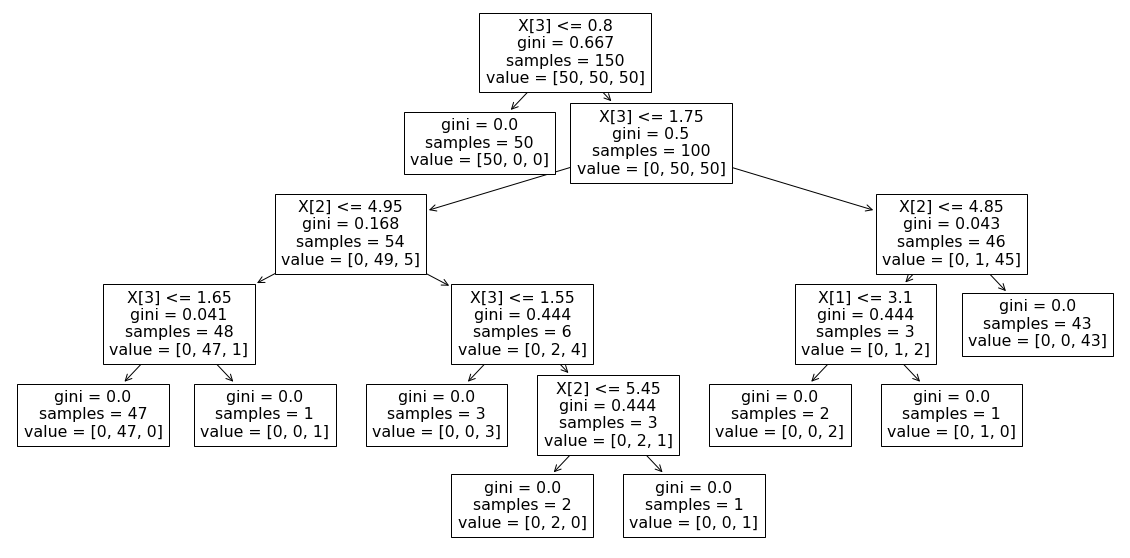

In [30]:
# your code here
from sklearn.datasets import load_iris
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=13)
iris = load_iris()
clf = clf.fit(iris.data, iris.target)
plt.figure(figsize=(20,10))
tree.plot_tree(clf)
# plt.figure(figsize=(20,10))

## 5

Read about different validation strategies:

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators

Split the data into 5 folds using `KFold` method from `sklearn`. Active shuffling of the data, use `random_state=13` and other default parameter values.

**q5:** Calculate the mean value of the target in validation for each split of the data (`kf.split(df)`). What if the mean value of the target in validation in the FIRST such split? Provide the answer, rounded to the nearest FIVE decimal places (e.g. 12.3456789 -> 12.34568).

In [44]:
# your code here
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=13, shuffle=True)
for train, test in kf.split(X):
    print((train,test))
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

(array([   0,    1,    2, ..., 1991, 1992, 1993]), array([   3,    5,   15,   16,   19,   22,   23,   24,   25,   26,   29,
         30,   32,   33,   35,   44,   45,   52,   67,   70,   82,   83,
         84,   85,   99,  103,  107,  110,  112,  115,  117,  129,  135,
        142,  144,  152,  160,  163,  167,  170,  177,  185,  194,  195,
        200,  201,  207,  210,  214,  215,  217,  224,  227,  228,  231,
        240,  242,  248,  266,  267,  275,  284,  286,  289,  290,  291,
        292,  293,  295,  304,  306,  316,  319,  320,  321,  329,  330,
        346,  351,  362,  363,  364,  366,  381,  404,  405,  413,  418,
        426,  433,  437,  440,  441,  442,  446,  448,  449,  452,  458,
        470,  473,  480,  484,  489,  491,  506,  517,  518,  519,  523,
        525,  540,  546,  557,  573,  576,  581,  589,  593,  595,  596,
        603,  605,  613,  618,  620,  632,  639,  640,  643,  647,  648,
        651,  659,  660,  661,  664,  667,  671,  680,  681,  682,  685,


KeyError: "None of [Int64Index([   0,    1,    2,    4,    6,    7,    8,    9,   10,   11,\n            ...\n            1979, 1980, 1982, 1983, 1985, 1988, 1989, 1991, 1992, 1993],\n           dtype='int64', length=1595)] are in the [columns]"

## 6

Use the same KFold splitting as in the task 5. On each step of cross-validation, train Linear Regression from `sklearn` with the default parameters on train folds, make a prediction on the validation fold and compute its Mean Squared Error with the true target values. After running the cross-validation process, you should obtain five different MSE values. 

**q6:** What is their mean (mean CV score)? Provide the answer, rounded to the nearest FIVE decimal places (e.g. 12.3456789 -> 12.34568).

In [34]:
# your code here
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=13, shuffle=True)
for train, test in kf.split(X):
    print((train.mean(),test.mean()))

(1003.4219435736677, 968.8295739348371)
(987.6394984326018, 1031.919799498747)
(1012.894670846395, 930.9624060150376)
(987.6733542319749, 1031.7844611528822)
(990.874060150376, 1019.0603015075377)


## 7

Using the same training procedure as in the the task 6, compute feature importances of linear regression model on each step of your 5-fold cross-validation. Since all our features are from the range 0 to 1, we can think of linear regression weights as feature importances. Store them in some convenient data structure, so that it is easy to access a certain feature importance on a cetrain fold. For instance, you can store them in such dataframe:

||fold_1|fold_2|...|
|-|-|-|-|
|feature_1|0.05|0.5|...|
|feature_2|-0.6|-1.8|...|
|...|...|...|...|

**q7:** What is the importance of `'NumUnderPov'` feature on fold #4 (if we enumerate folds, starting with 1 - folds #1, #2, #3, #4, #5)? Provide the answer, rounded to the nearest FIVE decimal places (e.g. 12.3456789 -> 12.34568).

In [ ]:
# your code here

## 8

In the task 7, we have computed feature importances on each fold. How to compute feature importances in general - on the whole data? One way is to simply compute the average of these feature importances that we have already obtained.

For each feature, take its importances on each fold and compute their mean value. In practice, it is easy to do if you store your data in the dataframe.

**q8:** What is the most important feature according to the linear regression? Provide the name of the feature with the highest ABSOLUTE VALUE of the mean feature importance.

Look at the description of this feature. How do you think - why it can be considered as an important feature for the model?

In [ ]:
# your code here

## 9

Now use a regular train/test split (a method from `sklearn`) to split `X` and `y` into train and validation parts in the ratio 4:1. Use `random_state=13` and other default parameter values of `train_test_split`.

Take a LightGBM Regressor from `lightgbm` with 1000 trees, maximum depth equal to 4, `random_state=13` and other default parameter values. Train it on the train part. Compute its mean squared error on the validation part. 

**q9:** What is this mean squared error equal to? Provide the answer, rounded to the nearest FIVE decimal places (e.g. 12.3456789 -> 12.34568).

In [ ]:
# your code here

## 10

In this and all the following tasks, use the trained LightGBM model from the task 9.

Calculate its feature importances (method `feature_importances_`). Sort these values. 

**q10:** What is the name of the SIXTH most important feature?

Look at the description of this feature. How do you think - why it can be considered as an important feature for the model?

In [ ]:
# your code here

## 11

Answer the question, using Partial Dependence Plots for the following features:

* `'PctVacMore6Mos'`
* `'indianPerCap'`
* `'OtherPerCap'`
* `'racePctHisp'`
* `'NumStreet'`
* `'PctPolicAsian'`

Suppose that you increase feature value from minimum to maximum for all observations. 

**q11:** For how many of the abovementioned features, this change results in the negative trend of the prediction on the validation set? In a more formal way, compute the number (from 0 to 6) of features such that their maximum value produces a smaller average prediction value than their minimum value.

Read the description of the mentioned features. How do you think - why do you observe such trends for this features?

You can use `plot_partial_dependence` function from `sklearn.inspection` with `random_state=13`. Other non-required parameters can have default values.

_Hint: to make plots bigger, you can initiate your figure with `fig, ax = plt.subplots(figsize=<your_figsize>)`, and then pass `ax=ax` parameter into the PDP function._

In [ ]:
# your code here

## 12

Now compute the most important feature for the model, using permutation importance technique. Use `sklearn.inspection.permutation_importance` function for the model on the validation set. Measure permutation importance according to the MSE (`scoring='neg_mean_squared_error'`). Repeat the procedure 7 times (`n_repeats=7`). Use `random_state=13` and other default parameter values.

**q12:** What is the most important feature? Provide the name of this feature for the answer. What do you think, why is this feature important?

In [ ]:
# your code here

## 13

Now we will use LIME method to explain model prediction. Take `LimeTabularExplainer` from `lime`. Initialize it with `training_data=X_train.values` (it is not possible at the time to use `pandas.DataFrame` here, so instead we use `numpy.array`), `mode='regression'`, `feature_names=X_train.columns`, `random_state=13` and other default parameter values.

Using this explainer, explain model prediction for the first observation in the validation set (`X_val.iloc[0]`), with maximum number of features equal to 10 (`num_features=10` - this is the default parameter value for `explainer.explain_instance` function). Visualize the result (`exp.show_in_notebook(show_table=True)`).

**q13:** How many features among top-10 for this observation make a positive impact on the prediction (increase the predicted value)? As an answer, provide the number from 0 to 10.

Think about how you could explain this model behaviour, seeing the results of LIME method.

In [ ]:
# your code here

## 14

Now use SHAP values to explain the prediction. Take `TreeExplainer` from `shap` and initialize it for the original model. Compute shap values by running `explainer.shap_values` on the validation set. Plot the explanation of model prediction for the last observation in the validation set via `shap.force_plot` with the following parameter values:

* `base_value=explainer.expected_value` - the reference value that the feature contributions start from;
* `shap_values=shap_values[-1, :]` - SHAP values for the last observation in the validation set;
* `features=X_val.iloc[-1, :]` - feature values for the last observation in the validation set;
* `matplotlib=True` - use matplotlib instead of Javascript to visualize the results;
* other default parameter values.

Looking at the result, answer the following question. 

**q14:** Which feature provides the biggest contribution to the prediction for the described observation?

Look at the description of this feature. How do you think - why it can be considered as an important feature for the model?

In [ ]:
# your code here

## 15

Finally, visualize a bar plot of mean absolute values of the SHAP values for each feature in the validation set (`features=X_val`). To do this, you can use `shap.summary_plot` function. Pass the computed SHAP values in the task 14 into it. Use `plot_type='bar'` to obtain a bar plot and other default parameter values.

**q15:** What is the THIRD most important feature overall, according to SHAP values?

Look at the description of this feature. How do you think - why it can be considered as an important feature for the model?

In [ ]:
# your code here